In [11]:
import pandas as pd
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, sampler
from torch import nn
import matplotlib.pyplot as plt
from torchmetrics.classification import BinaryJaccardIndex
from torch.utils.tensorboard import SummaryWriter
#from dataset_class import GeoImageDataset
from rasterio.plot import show
import segmentation_models_pytorch as smp
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
import shutil
from pathlib import Path

In [12]:
class GeoImageDataset(Dataset):
    def __init__(self, img_dir: Path, mask_dir:Path, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_files = os.listdir(self.img_dir)
        self.mask_files = os.listdir(self.mask_dir)
        self.transform = transform
        

    def __len__(self):
        return len(self.img_files)
        
    def __getitem__(self, idx):
        # Load image
        img_path = self.img_dir / self.img_files[idx]
        # mask and img_file have so far the same name
        mask_path = self.mask_dir / self.img_files[idx]
        img = torch.load(img_path)
        # converts bool mask into integer (0/1)
        mask = torch.load(mask_path).long()
        # Apply transform (if any)
        if self.transform:
            img = self.transform(img)
        
        return img, mask #, img_path, mask_path

In [13]:
img_dir = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\images_only_AOI_test_color_corr')
mask_dir = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\masks_only_AOI_test_color_corr')
target_img_dir = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\images_only_AOI_test_color_corr_cleaned')
target_mask_dir = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\masks_only_AOI_test_color_corr_cleaned')
geo_image_dataset = GeoImageDataset(img_dir, mask_dir)
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")
# select Unet with resnet34 as backbone
model = smp.Unet(
    encoder_name="timm-efficientnet-b0", # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=4,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
    activation='sigmoid',
).cuda()

Using cuda device


In [14]:
model_dir = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\saved_models')
model_filename = 'eff_b0_all_seasons_cleaned_best_model.pth'
model_path = os.path.join(model_dir, model_filename)
model.load_state_dict(torch.load(model_path))
model.eval() # enabling the eval mode to test with new samples.
metric = BinaryJaccardIndex().to(device)

### export Model with jit to use it only in inference (with torchserve)

In [5]:
input = torch.randn(32, 4, 256, 256).to(device)
torch.onnx.export(model, input, 'model.onnx')

c:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\.venv\lib\site-packages\segmentation_models_pytorch\base\model.py:16: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h % output_stride != 0 or w % output_stride != 0:


============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [20]:
import onnx
model = onnx.load("model.onnx")
# Check that the model is well formed
onnx.checker.check_model(model)

# Konvertieren Sie das Modell in ein PyTorch-Modell
model = torch.nn.Sequential(model)

TypeError: onnx.onnx_ml_pb2.ModelProto is not a Module subclass

In [6]:
torch.save(model, 'model.pt')

In [17]:
model = torch.load('model.pt')

In [8]:
#input = torch.randn(32, 4, 256, 256)
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save(model_dir / 'eff_b0_scripted.pt') # Save

OSError: Can't get source for <class 'onnx.onnx_ml_pb2.ModelProto'>. TorchScript requires source access in order to carry out compilation, make sure original .py files are available.

In [18]:
img, mask = geo_image_dataset[500]
img = img.to(device)
mask = mask.to(device)

# Run forward pass
with torch.no_grad():
  pred = model(img.unsqueeze(0))

100*metric(pred[:,0], mask.unsqueeze(0))
pred_np = pred.detach().cpu().numpy()
img_np = img.detach().cpu().numpy()
mask_np = mask.detach().cpu().numpy()

TypeError: 'ModelProto' object is not callable

In [38]:
index_list = []
metric_list = []
mask_size_list = []
brightness_image_list = []

for i, sample in enumerate(geo_image_dataset):
    img, mask = geo_image_dataset[i]
    img = img.to(device)
    mask = mask.to(device)
    if mask.sum() <= 300:
        continue
    with torch.no_grad():
        pred = model(img.unsqueeze(0))
    
    IoU = metric(pred[:,0], mask.unsqueeze(0)).cpu().numpy()
    index_list.append(i)
    metric_list.append(IoU)
    mask_size_list.append(mask.sum().cpu().numpy())
    brightness_image_list.append(img.mean().cpu().numpy())

# Erstellen Sie einen DataFrame mit dem Index und den Ergebnissen
df = pd.DataFrame({'index': index_list, 'metric': metric_list, 'mask_size': mask_size_list, 'brightness': brightness_image_list})

# Sortieren Sie den DataFrame nach den Metrikergebnissen
df = df.sort_values('metric', ascending=False)

# Drucken Sie den DataFrame
df.head()

,index,metric,mask_size,brightness
3237,5707,0.9823466,4595,0.24523072
3240,5710,0.9786131,4595,0.2594727
3215,5671,0.97720385,6863,0.27843425
3897,6780,0.9737345,2065,0.28302726
4112,7073,0.97152674,4024,0.18375213


# clean data

In [5]:
for i, sample in enumerate(geo_image_dataset):
    img, mask, image_path, mask_path = geo_image_dataset[i]
    img = img.to(device)
    mask = mask.to(device)
    if mask.sum() <= 200:
        continue
    with torch.no_grad():
        pred = model(img.unsqueeze(0))
    
    IoU = metric(pred[:,0], mask.unsqueeze(0)).cpu().numpy()
    if IoU < 0.01:
        continue
    else:
        shutil.copy(image_path, target_img_dir/image_path.name)
        shutil.copy(mask_path, target_mask_dir/mask_path.name)

<Axes: >

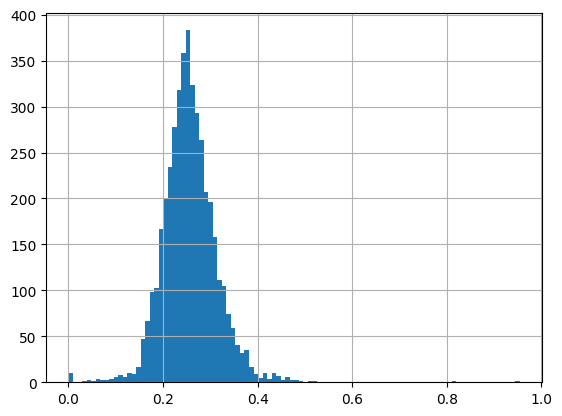

In [42]:
df.brightness.hist(bins=100)

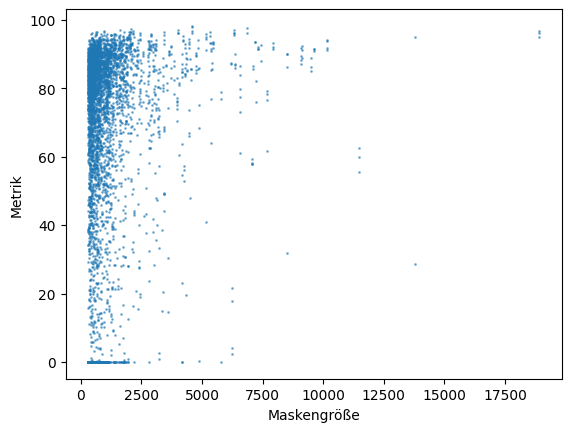

In [13]:
plt.scatter(size_list, metric_list, s=1, alpha=0.5)

# Labeln Sie die Achsen
plt.xlabel('Maskengröße')
plt.ylabel('Metrik')

# Zeigen Sie den Plot an
plt.show()

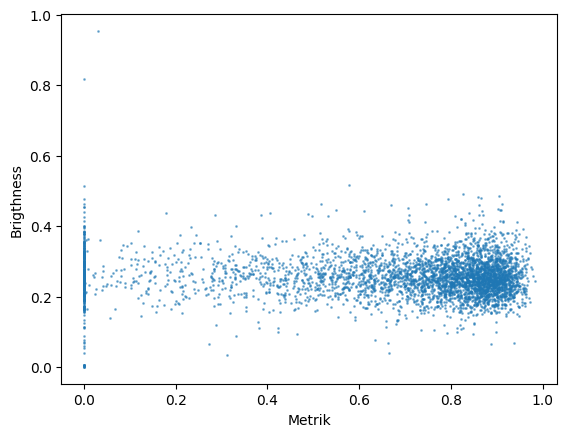

In [44]:
plt.scatter(metric_list,brightness_image_list, s=1, alpha=0.5)

# Labeln Sie die Achsen
plt.ylabel('Brigthness')
plt.xlabel('Metrik')

# Zeigen Sie den Plot an
plt.show()

In [45]:
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

<Axes: >

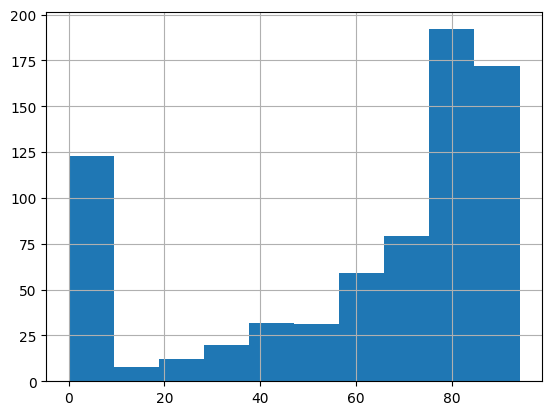

In [29]:
df[df.mask_size < 400].metric.hist()

In [56]:
df = df.sort_values('metric', ascending=True)
df.head(100)

,index,metric
1016,2026,0.0
1766,3435,0.0
173,273,0.0
4171,7140,0.0
4170,7139,0.0
...,...,...
2014,3815,0.0
1637,3204,0.0
1682,3288,0.0
1632,3191,0.0


<Axes: ylabel='Frequency'>

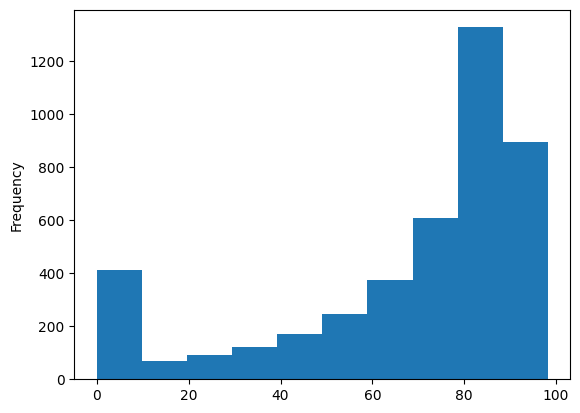

In [55]:
df.metric.plot.hist()

In [60]:
df.metric.mean()

67.47613969358278

In [43]:
df.to_csv('metric_results.csv', sep=';', index=False)

In [62]:
img, mask = geo_image_dataset[3435]
img = img.to(device)
mask = mask.to(device)

# Run forward pass
with torch.no_grad():
  pred = model(img.unsqueeze(0))

pred_np = pred.detach().cpu().numpy()
img_np = img.detach().cpu().numpy()
mask_np = mask.detach().cpu().numpy()
100*metric(pred[:,0], mask.unsqueeze(0))

tensor(0., device='cuda:0')

In [19]:
def show_rgb_sample(sample):
    img, mask = sample
    plt.figure(figsize=(8, 8))
    plt.imshow(torch.Tensor.numpy(img[1:4,:,:]).transpose((1,2,0)))
    plt.imshow(torch.Tensor.numpy(mask), cmap='jet', alpha=0.5*(torch.Tensor.numpy(mask)==True))

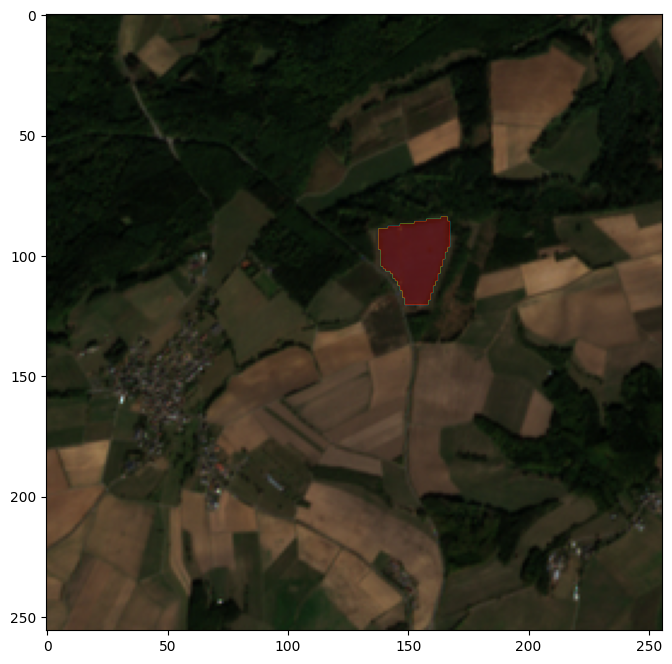

In [51]:
show_rgb_sample(geo_image_dataset[3])

# After cleaning

In [8]:
img_dir = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\images_only_AOI_test_color_corr_cleaned')
mask_dir = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\masks_only_AOI_test_color_corr_cleaned')

geo_image_dataset = GeoImageDataset(img_dir, mask_dir)
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")
# select Unet with resnet34 as backbone
model = smp.Unet(
    encoder_name="timm-efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=4,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
    activation='sigmoid', 
).cuda()

Using cuda device


In [9]:
model_dir = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\saved_models')
model_filename = 'eff_b0_all_seasons_cleaned_dropped_best_model.pth'
model_path = os.path.join(model_dir, model_filename)
model.load_state_dict(torch.load(model_path))
model.eval() # enabling the eval mode to test with new samples.
metric = BinaryJaccardIndex().to(device)

In [11]:
torch.save(model, model_dir / 'eff_b0_pre_scripted.pt')

In [15]:
import io
model = torch.load(io.BytesIO(model_dir / 'eff_b0_pre_scripted.pt'))
model.eval()

# model_scripted = torch.jit.script(model) # Export to TorchScript
# model_scripted.save(model_dir / 'eff_b0_scripted.pt') # Save

TypeError: a bytes-like object is required, not 'WindowsPath'

In [53]:
image, mask = geo_image_dataset[3]
image.mean()

tensor(0.2634)

In [10]:
index_list = []
metric_list = []
mask_size_list = []
brightness_image_list = []

for i, sample in enumerate(geo_image_dataset):
    img, mask = geo_image_dataset[i]
    img = img.to(device)
    mask = mask.to(device)
    if mask.sum() <= 300:
        continue
    with torch.no_grad():
        pred = model(img.unsqueeze(0))
    
    IoU = metric(pred[:,0], mask.unsqueeze(0)).cpu().numpy()
    index_list.append(i)
    metric_list.append(IoU)
    mask_size_list.append(mask.sum().cpu().numpy())
    brightness_image_list.append(img.mean().cpu().numpy())

# Erstellen Sie einen DataFrame mit dem Index und den Ergebnissen
df = pd.DataFrame({'index': index_list, 'metric': metric_list, 'mask_size': mask_size_list, 'brightness': brightness_image_list})

# Sortieren Sie den DataFrame nach den Metrikergebnissen
df = df.sort_values('metric', ascending=True)

# Drucken Sie den DataFrame
df.head()

,index,metric,mask_size,brightness
2910,3476,0.9808437,4595,0.24523072
2511,3032,0.97610515,824,0.17468807
3743,4458,0.9748781,4024,0.22253874
2912,3478,0.97439235,4595,0.24491556
2913,3479,0.97377545,4595,0.2594727


In [12]:
df = df.sort_values('metric', ascending=True)
df.head(10)

,index,metric,mask_size,brightness
682,843,0.0,450,0.30635986
3563,4258,0.0,2962,0.1101598
2358,2843,0.0,338,0.1656249
3380,4043,0.0,336,0.29014432
2367,2853,0.0,403,0.24250361
2368,2854,0.0,530,0.23871745
2369,2855,0.0,530,0.3167435
803,978,0.0,650,0.32629263
804,979,0.0,650,0.34716415
1308,1611,0.0,965,0.27160355


<Axes: >

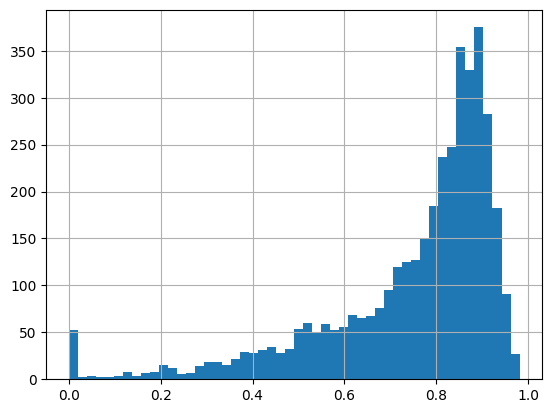

In [16]:
df.metric.hist(bins=50)

In [26]:
img, mask = geo_image_dataset[4043]
img = img.to(device)
mask = mask.to(device)

# Run forward pass
with torch.no_grad():
  pred = model(img.unsqueeze(0))

pred_np = pred.detach().cpu().numpy()
img_np = img.detach().cpu().numpy()
mask_np = mask.detach().cpu().numpy()
100*metric(pred[:,0], mask.unsqueeze(0))

tensor(0., device='cuda:0')

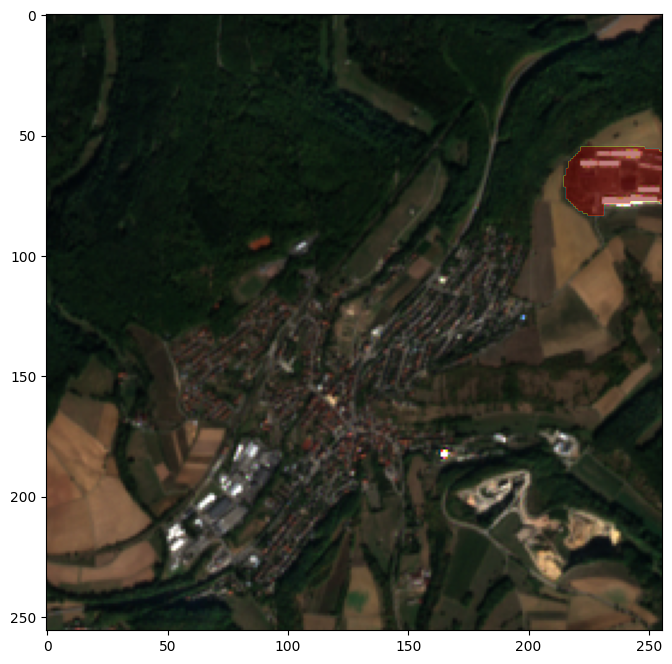

In [29]:
show_rgb_sample(geo_image_dataset[1611])

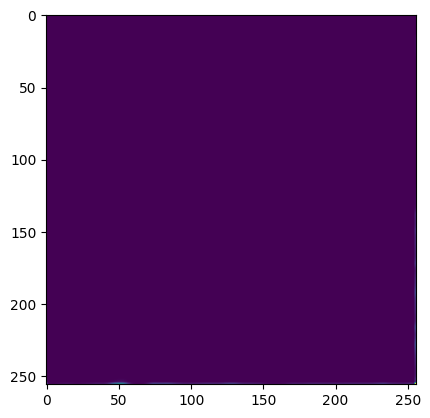

<Axes: >

In [30]:
show(pred_np)

In [52]:
mask.sum()

tensor(170, device='cuda:0')

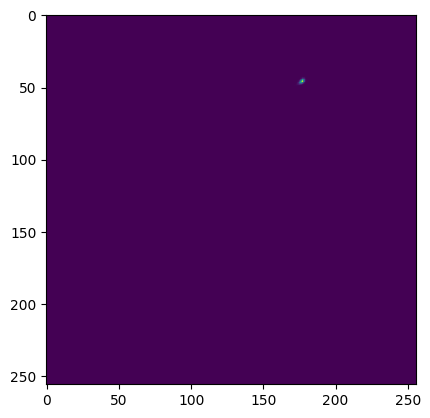

<Axes: >

In [68]:
show(pred_np)